## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Directory

In [2]:
homepath = "C:/A.PROJECTS/stockprediction/"

## Data

In [3]:
stock_prices = pd.read_csv(homepath + 'data/stock_prices_30_tickers.csv',parse_dates=['Date'], index_col='Date')

In [4]:
def compute_returns(df):
    """
    Computes weekly, monthly, quarterly, and annual simple and log returns
    from a DataFrame of daily adjusted prices.

    Args:
        df (pd.DataFrame): DataFrame with daily adjusted prices. The index should be datetime.

    Returns:
        dict: A dictionary containing DataFrames for weekly, monthly, quarterly, and annual simple and log returns.
    """

    # Ensure the index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")

    # Function to calculate simple returns
    def calculate_simple_returns(data):
        return data.pct_change().dropna()

    # Function to calculate log returns
    def calculate_log_returns(data):
        return np.log(data).diff().dropna()

    # Resample data and calculate simple returns
    weekly_simple_returns = calculate_simple_returns(df.resample('W').last())
    monthly_simple_returns = calculate_simple_returns(df.resample('M').last())
    quarterly_simple_returns = calculate_simple_returns(df.resample('Q').last())
    annual_simple_returns = calculate_simple_returns(df.resample('Y').last())

    # Resample data and calculate log returns
    weekly_log_returns = calculate_log_returns(df.resample('W').last())
    monthly_log_returns = calculate_log_returns(df.resample('M').last())
    quarterly_log_returns = calculate_log_returns(df.resample('Q').last())
    annual_log_returns = calculate_log_returns(df.resample('Y').last())

    return {
        'weekly_simple': weekly_simple_returns,
        'monthly_simple': monthly_simple_returns,
        'quarterly_simple': quarterly_simple_returns,
        'annual_simple': annual_simple_returns,
        'weekly_log': weekly_log_returns,
        'monthly_log': monthly_log_returns,
        'quarterly_log': quarterly_log_returns,
        'annual_log': annual_log_returns
    }

In [5]:
rets = compute_returns(stock_prices)

## PCA (Principal Component Analysis)

In [6]:
def PCA_Factoring(returns_df, n_factors):
    """
    Builds a statistical factor model using PCA.

    Args:
        returns_df (pd.DataFrame): DataFrame of asset returns (tickers as columns).
        n_factors (int): Number of factors to extract.

    Returns:
        tuple: (loadings_df, explained_variance_ratio, pca_model)
               loadings_df: DataFrame of factor loadings (tickers as rows, factors as columns).
               explained_variance_ratio: Explained variance ratio for each factor.
               pca_model: The fitted PCA model.
    """

    # 1. Standardize the returns
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns_df)
    scaled_returns_df = pd.DataFrame(scaled_returns, index=returns_df.index, columns=returns_df.columns)

    # 2. Apply PCA
    pca = PCA(n_components=n_factors)
    pca.fit(scaled_returns_df)
    principal_components = pca.fit_transform(scaled_returns_df)

    # 3. Extract factor loadings
    loadings = pca.components_.T  # Transpose to get tickers as rows, factors as columns
    loadings_df = pd.DataFrame(loadings, index=returns_df.columns, columns=[f"Factor_{i+1}" for i in range(n_factors)])

    # 4. Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    return loadings_df, explained_variance_ratio, pca, principal_components

In [7]:
returns_df = rets['weekly_log']
n_factors = 5
loadings_df, explained_variance_ratio, pca_model, principal_components = PCA_Factoring(returns_df, n_factors)

print("Factor Loadings:")
print(loadings_df)
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)



Factor Loadings:
       Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
AAPL   0.216231  0.125278  0.067759 -0.153459  0.064833
ADBE   0.186728  0.263048 -0.016157 -0.065315 -0.146709
AMZN   0.154957  0.320156 -0.053680  0.194803  0.061298
AVGO   0.219715  0.028568 -0.060590 -0.093071  0.266695
BAC    0.190632 -0.197954 -0.304594  0.116857 -0.091110
CRM    0.174794  0.252194 -0.105660  0.017928 -0.147706
CSCO   0.187967 -0.079070  0.180486  0.298610  0.018996
CVX    0.160791 -0.293756 -0.183107  0.070892  0.026175
DIS    0.205975 -0.067725 -0.134080  0.188021 -0.073290
GOOGL  0.208403  0.153543 -0.102899  0.000760 -0.083662
IBM    0.182203 -0.234715  0.002438 -0.049496  0.100122
INTC   0.181586 -0.067572 -0.036043 -0.064554  0.362443
JNJ    0.166249 -0.144217  0.371822 -0.038686 -0.053812
JPM    0.193189 -0.206022 -0.250874  0.070922 -0.089906
KO     0.204219 -0.210468  0.138976 -0.114405 -0.087891
META   0.149022  0.209183 -0.133504 -0.241682 -0.341683
MSFT   0.217181  0.204162  0.04

In [8]:
# Create a DataFrame for principal components
pc_df = pd.DataFrame(
    principal_components,
    index=returns_df.index,
    columns=[f"PC_{i+1}" for i in range(n_factors)]
)
# Shift the principal components to create lagged features
lags = 1  # Use 1-period lag
for i in range(1, lags + 1):
    pc_df[[f"PC_{j+1}_lag{i}" for j in range(n_factors)]] = pc_df.shift(i)

# Drop rows with missing values (due to lagging)
pc_df.dropna(inplace=True)

# Add the target variable (future returns of an asset)
sample_AAPL = pd.concat([pc_df, returns_df['AAPL'].shift(-1)], axis=1).dropna()

### Forecast

In [16]:
# Features (lagged PCA factors) and target (future returns for prediction)
X = sample_AAPL.drop(columns=["AAPL"])
y = sample_AAPL["AAPL"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.002852596391325888


### Clustering Timeseries based on PCA

Explained variance by top 5 components: [0.6164045  0.07937575 0.05481234 0.03707992 0.02766959]


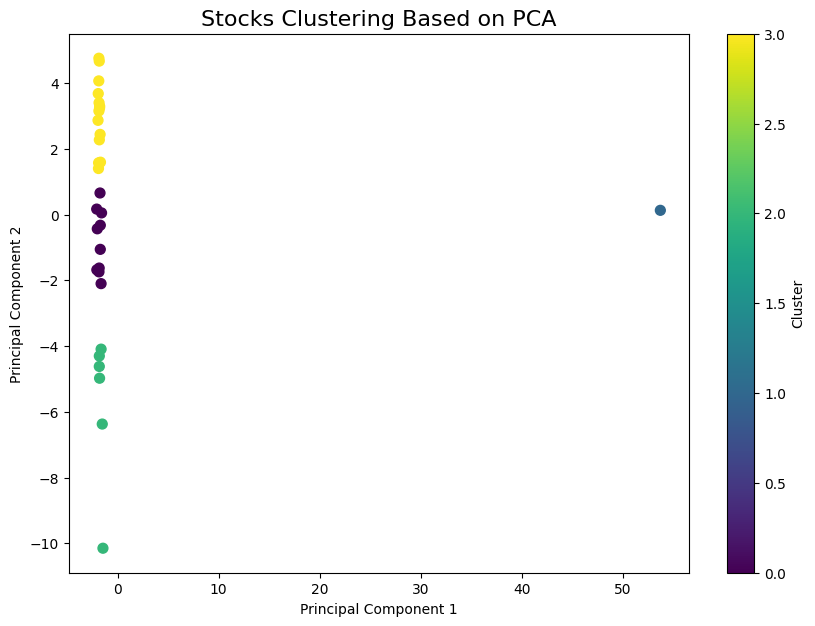

Cluster 0: AAPL, AVGO, DIS, GOOGL, INTC, META, MSFT, QCOM, TXN, V
Cluster 1: Cluster
Cluster 2: ADBE, AMZN, CRM, NFLX, NVDA, TSLA
Cluster 3: BAC, CSCO, CVX, IBM, JNJ, JPM, KO, ORCL, PEP, PFE, PG, T, WMT, XOM


In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = rets['weekly_log']
stock_names = df.columns

# Step 1: Normalize the data (transpose before scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.T).T # Scale each stock's returns

# Step 2: Apply PCA
pca = PCA(n_components=5)  # Project into 5 principal components
pca_result = pca.fit_transform(scaled_data.T) # PCA on stocks
print(f"Explained variance by top 5 components: {pca.explained_variance_ratio_}")

# Use the first 2 components for visualization
pca_data_2D = pca_result[:, :2]

# Step 3: Cluster using K-Means
n_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_data_2D)

# Create a DataFrame for the PCA results and cluster assignments
pca_df = pd.DataFrame(pca_result)
pca_df['Cluster'] = clusters
pca_df['Stock'] = stock_names

# Step 4: Visualize the Clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_data_2D[:, 0], pca_data_2D[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("Stocks Clustering Based on PCA", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Step 5: List clusters
for cluster in range(n_clusters):
    cluster_stocks = pca_df[pca_df['Cluster'] == cluster]['Stock'].tolist()
    print(f"Cluster {cluster}: {', '.join(cluster_stocks)}")


### Absorption Ratio (systemic risk index using PCA)
* source: http://web.mit.edu/finlunch/Fall10/PCASystemicRisk.pdf

**Explanation:**
- The **Absorption Ratio** measures the proportion of total variance that is "absorbed" by the dominant components (\(N\) largest eigenvalues). 
- The numerator, represents the variance explained by the top \(N\) principal components, which capture the most significant sources of systemic variation in asset returns.
- The denominator, represents the total variance of the assets, encapsulating the overall risk in the system.

---

**Key Interpretations:**
1. **High Absorption Ratio (AR):**
   - Indicates strong market coupling (assets are more interdependent).
   - Suggests higher susceptibility to systemic risk and contagion during financial stress.

2. **Low Absorption Ratio (AR):**
   - Indicates that risks are more dispersed, with weaker connections among assets.
   - Associated with periods of market stability and reduced systemic fragility.

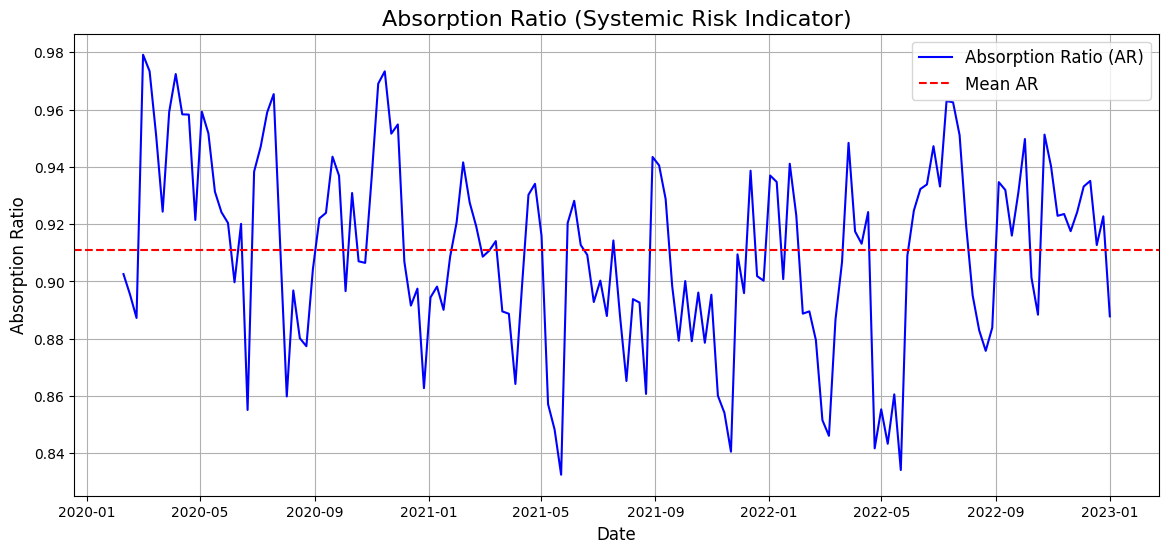

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Load financial market data (e.g., simulated or downloaded).

returns_data = rets['weekly_log']

# Step 2: Compute the rolling 252-day Absorption Ratio (1-year window)
def compute_absorption_ratio(data, n_components=3, window=252):
    """
    Computes the absorption ratio over a rolling window.
    - data: DataFrame of asset returns
    - n_components: Number of principal components to include in AR
    - window: Rolling window size (e.g., 252 for 1 year of daily returns)
    """
    scaler = StandardScaler()  # Standardize data
    absorption_ratios = []

    for i in range(window, len(data) + 1):
        # Take a rolling window slice
        window_data = data.iloc[i - window:i]
        window_data_scaled = scaler.fit_transform(window_data)

        # Perform PCA
        pca = PCA()
        pca.fit(window_data_scaled)

        # Compute explained variance by the top n_components
        explained_variance_ratio = np.sum(pca.explained_variance_ratio_[:n_components])

        # Append the absorption ratio for this window
        absorption_ratios.append(explained_variance_ratio)

    # Pad the initial period with NaNs
    absorption_ratios = [np.nan] * (window - 1) + absorption_ratios
    return pd.Series(absorption_ratios, index=data.index)

# Calculate the Absorption Ratio
ar_series = compute_absorption_ratio(returns_data, n_components=3, window=5)

# Step 3: Plot the Absorption Ratio
plt.figure(figsize=(14, 6))
plt.plot(ar_series, label='Absorption Ratio (AR)', color='b')
plt.axhline(y=np.nanmean(ar_series), color='r', linestyle='--', label='Mean AR')
plt.title('Absorption Ratio (Systemic Risk Indicator)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Absorption Ratio', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Step 4: Observations: Identify spikes and slowdowns
# Mark notable regions of risk (spikes) and stability (low AR)


### DPCA (Dynamic PCA)
* https://medium.com/@quantclubiitkgp/unraveling-risk-insights-with-principal-component-analysis-692f8e3b389b
* https://www.sciencedirect.com/science/article/abs/pii/S0951832023005227

The systemic risk indicator plot has been saved to: systemic_risk_indicator.png


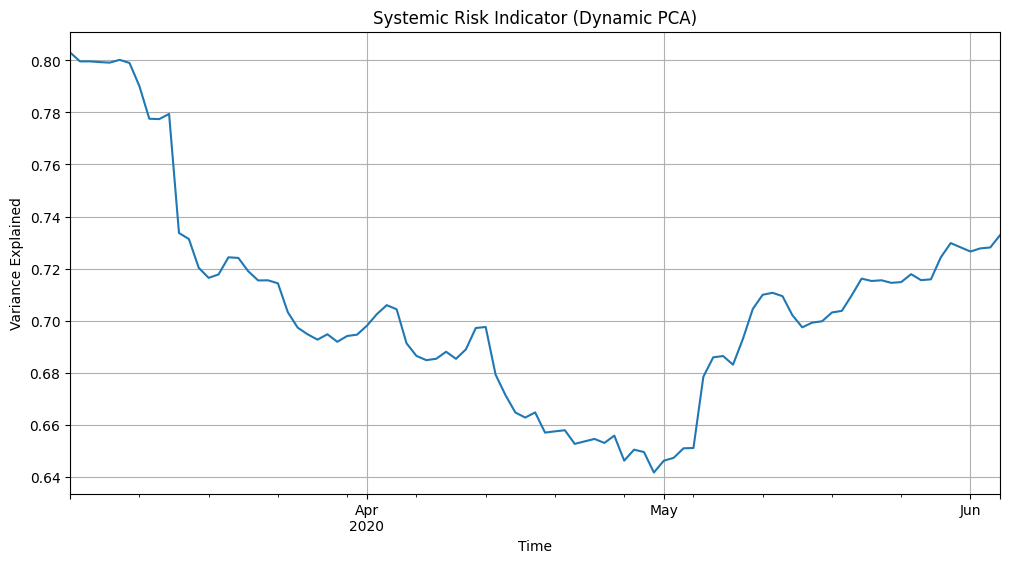

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

num_periods = 156
data = rets['weekly_log']

# Create a date index
date_index = pd.date_range(start='2020-01-01', periods=num_periods, freq='D')
data.index = date_index

# Handle missing data (simple imputation - not really needed here, but good practice)
data = data.fillna(data.mean())

# Ensure stationarity (first differencing)
data_diff = data.diff().dropna()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_diff)

# Convert to DataFrame for easier handling
scaled_data = pd.DataFrame(scaled_data, index=data_diff.index, columns=data_diff.columns)

# Rolling window PCA
window_size = 60  # 60 days rolling window (adjust as needed)
n_components = 5   # Number of principal components to retain
explained_variance_ratio_list = []
dates = []

for i in range(window_size, len(scaled_data)):
    window = scaled_data.iloc[i-window_size:i]
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(window)
    
    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance_ratio_list.append(explained_variance_ratio)
    dates.append(scaled_data.index[i])

# Convert to DataFrame for easier handling
explained_variance_df = pd.DataFrame(explained_variance_ratio_list, index=dates)
explained_variance_df.columns = [f'PC{i+1}' for i in range(n_components)]

# Systemic Risk Indicator: Sum of variance explained by the first few components
systemic_risk_indicator = explained_variance_df.sum(axis=1)

# Plot the systemic risk indicator
plt.figure(figsize=(12, 6))
systemic_risk_indicator.plot(title='Systemic Risk Indicator (Dynamic PCA)')
plt.xlabel('Time')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.savefig('systemic_risk_indicator.png')
print("The systemic risk indicator plot has been saved to: systemic_risk_indicator.png")

# Display the plot (optional)
plt.show()


## ICA (Independent Component Analysis)

In [13]:
def independent_component_analysis(returns_df, n_factors):
    """
    Extracts independent factors from asset return data using ICA.

    Args:
        returns_df (pd.DataFrame): DataFrame of asset returns (tickers as columns).
        n_factors (int): Number of independent factors to extract.

    Returns:
        tuple: (independent_factors, mixing_matrix, ica_model)
               independent_factors: DataFrame of extracted factors (time series).
               mixing_matrix: Mixing matrix (tickers as columns, factors as rows).
               ica_model: The fitted ICA model.
    """

    # 1. Standardize the returns
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns_df)
    scaled_returns_df = pd.DataFrame(scaled_returns, index=returns_df.index, columns=returns_df.columns)

    # 2. Apply ICA
    ica = FastICA(n_components=n_factors, max_iter=1000, random_state=42)
    independent_factors = ica.fit_transform(scaled_returns_df)  # Independent factors (time series)
    mixing_matrix = ica.mixing_  # Mixing matrix (factor loadings)

    # Convert results into DataFrames
    independent_factors_df = pd.DataFrame(
        independent_factors,
        index=returns_df.index,
        columns=[f"Factor_{i+1}" for i in range(n_factors)]
    )
    mixing_matrix_df = pd.DataFrame(
        mixing_matrix,
        index=returns_df.columns,
        columns=[f"Factor_{i+1}" for i in range(n_factors)]
    )
    
    return independent_factors_df, mixing_matrix_df, ica

In [14]:

returns_df = rets['weekly_log']
n_factors = 5
independent_factors_df, mixing_matrix_df, ica_model = independent_component_analysis(returns_df, n_factors)

print("Independent Factors (Time Series):")
print(independent_factors_df.head())

print("\nMixing Matrix (Factor Loadings):")
print(mixing_matrix_df)

Independent Factors (Time Series):
            Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
Date                                                        
2020-01-12 -1.076463 -0.177190 -0.673862 -0.635348  0.056670
2020-01-19 -0.563806  0.560567 -0.634902 -0.482808  0.757158
2020-01-26  1.371271  0.530062  0.592835 -1.067160  0.063820
2020-02-02  0.160322  0.649500  0.491162  0.020610 -0.993313
2020-02-09 -0.352191  0.145411  0.813162 -0.444158  0.697154

Mixing Matrix (Factor Loadings):
       Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
AAPL  -0.368478  0.094423  0.259194 -0.403816  0.609861
ADBE  -0.616297 -0.015445  0.281555 -0.410295  0.347869
AMZN  -0.471099 -0.002395  0.557133 -0.430378  0.126384
AVGO  -0.126329 -0.051827  0.385797 -0.343048  0.693980
BAC   -0.160176 -0.373474  0.357761  0.262036  0.687713
CRM   -0.590555 -0.120307  0.350452 -0.341360  0.287520
CSCO  -0.207036  0.316047  0.467399  0.128128  0.545893
CVX    0.057889 -0.218412  0.250482  0.315940  0.712281


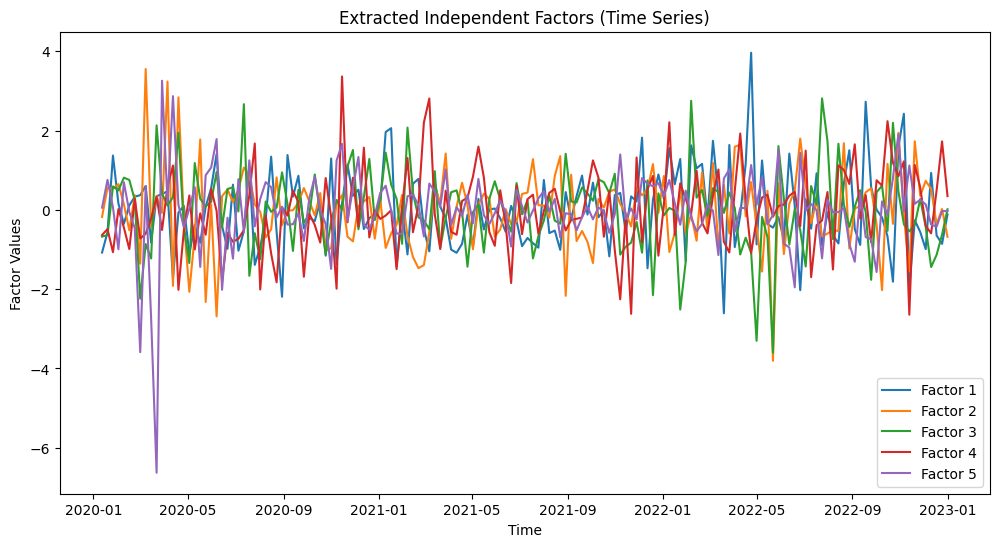

In [15]:
plt.figure(figsize=(12, 6))
for i in range(n_factors):
    plt.plot(independent_factors_df.index, independent_factors_df[f"Factor_{i+1}"], label=f"Factor {i+1}")
plt.title("Extracted Independent Factors (Time Series)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Factor Values")
plt.show()

## CCA (Canonical Correlation Analysis)